In [2]:
import tensorflow as tf
import gymnasium as gym
import matplotlib.pyplot as plt
from gymnasium.wrappers.monitoring.video_recorder import VideoRecorder
import tensorflow_probability as tfp
from IPython.display import clear_output
import time
import numpy as np
import sys

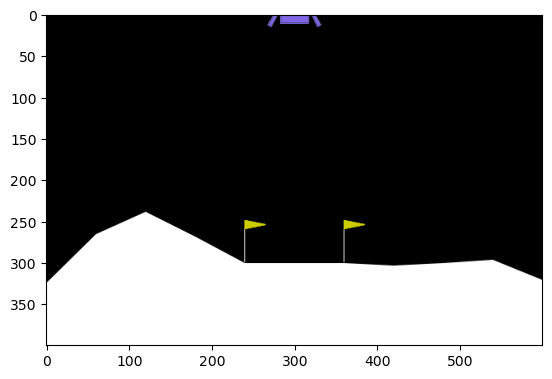

In [3]:
env = gym.make('LunarLander-v2', render_mode="rgb_array")
env.reset()
img = plt.imshow( env.render() )
states = env.observation_space.shape[0]

In [4]:
filename = 'videos/lunar_lander_'+name+'.mp4'
video = VideoRecorder(env,filename)
env.reset()
rewards = []
terminated=False
for _ in range(1000):
    env.render()
    video.capture_frame()
    obs, reward, terminated, truncated, info = env.step( env.action_space.sample() )
    rewards.append(reward)
    
    if terminated or truncated:
        observation, info = env.reset()
    
video.close()
env.close()

Moviepy - Building video videos/lunar_lander_lunar_lander_0.0002_gam=0.99_100epochs.mp4.
Moviepy - Writing video videos/lunar_lander_lunar_lander_0.0002_gam=0.99_100epochs.mp4



Moviepy - Done !
Moviepy - video ready videos/lunar_lander_lunar_lander_0.0002_gam=0.99_100epochs.mp4


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

def build_model( states, actions ):
    model = Sequential()
    model.add( Flatten(input_shape=(1,states)) )
    model.add( Dense(24, activation='relu') )
    model.add( Dense(24, activation='relu') )
    model.add( Dense(actions,activation='linear') )
    model.compile( Adam(lr=1e-3) )
    return model

In [6]:
class Policy_Network(tf.keras.Model):
    
    def __init__(self, n_actions):
        super(Policy_Network, self).__init__()
        self.fc1_dims = 300
        self.fc2_dims = 300
        self.n_actions = n_actions

        self.fc1 = Dense(self.fc1_dims, activation='relu')
        self.fc2 = Dense(self.fc2_dims, activation='relu')
        self.pi = Dense(n_actions, activation='softmax')

    def call(self, state):
        value = self.fc1(state)
        value = self.fc2(value)
        pi = self.pi(value)

        return pi
    
class Agent:
    
    def __init__(self, alpha=1e-3, n_actions=4, gamma=0.95):
        self.gamma = gamma
        self.n_actions = n_actions
        self.state_memory = []
        self.action_memory = []
        self.reward_memory = []
        self.mean_returns = []
        self.policy_network = Policy_Network( n_actions )
        self.policy_network.compile( optimizer=Adam(learning_rate=alpha))
        self.number_of_epochs_trained = 0

    def choose_action(self, state):
        state_tf = tf.convert_to_tensor([state])
        policy = self.policy_network(state_tf)
        action_probabilities = tfp.distributions.Categorical(probs=policy)
        action = action_probabilities.sample()

        return action.numpy()[0]
    
    def store_transition(self, observation, action, reward):
        self.state_memory.append(observation)
        self.action_memory.append(action)
        self.reward_memory.append(reward)
        
    def learn(self):

        batch_size = len( self.action_memory )

        G = [ [] for i in range(batch_size) ]
        for i in range( batch_size ):
            N_steps = len( self.reward_memory[i] )
            for t in range( N_steps ):
                G_sum = 0
                for k in range( N_steps-t ):
                    G_sum += self.reward_memory[i][t+k] * self.gamma**k
                G[i].append( tf.convert_to_tensor(G_sum) )
        
        with tf.GradientTape() as tape:
            loss=0.
            for i in range(batch_size):
                
                N_steps = len( self.reward_memory[i] )
                states_tf = tf.convert_to_tensor(self.state_memory[i])
                actions_tf = tf.convert_to_tensor(self.action_memory[i])
                probs = self.policy_network(states_tf)
                log_probs = tf.math.log( probs )
                          
                slice_indices = tf.transpose( tf.stack( (tf.range(0,N_steps), actions_tf) ) )
                log_probs_a = tf.gather_nd( log_probs, slice_indices )
                
                #probs_log_probs = probs * log_probs
                #sum_over_s_and_a = tf.reduce_sum( probs_log_probs )
                
                loss += - tf.reduce_sum( G[i][:] * log_probs_a )                
                    
            loss /= batch_size
                
        gradient = tape.gradient( loss, self.policy_network.trainable_variables )
        self.policy_network.optimizer.apply_gradients( zip(gradient, self.policy_network.trainable_variables) )

        self.state_memory = []
        self.action_memory = []
        self.reward_memory = []
        self.number_of_epochs_trained += 1

In [ ]:
num_epochs = 100
batch_size = 64
max_step_number = 150
number_of_prints = 10
lr=0.0002
gam=0.99

name='lunar_lander_'+str(lr)+'_gam='+str(gam)+'_'+str(num_epochs)+'epochs'
print('-- name: ', name)

pointer = 0
print_array=np.linspace( 0, 0.95, number_of_prints )

env = gym.make('LunarLander-v2')
env.reset()

agent = Agent( alpha=lr, n_actions=env.action_space.n, gamma=gam )

agent.state_memory = []
agent.action_memory = []
agent.reward_memory = []

t2=-1
t1=0

return_history=[]
for jj in range(num_epochs):
    
    t1 = time.time()
    batch_returns = []
    for ii in range(batch_size):
            
        seq_obsvs = []
        seq_acts = []
        seq_rwds = []
    
        observation, info = env.reset()
        step_number=0
        terminated=False
        
        while not terminated:
            step_number += 1
            action = agent.choose_action( observation )
            observation, reward, terminated, truncated, info = env.step( action )
            
            seq_obsvs.append( observation )
            seq_acts.append( action )
            seq_rwds.append( reward )
        
        agent.store_transition( seq_obsvs, seq_acts, seq_rwds )
        batch_returns.append( np.sum( seq_rwds ) )      
    
    return_history.append( np.mean( batch_returns ) )
    
    if (pointer < len(print_array))  and (jj > print_array[pointer]*num_epochs) :
        pointer+=1
        t2 = time.time()
        print('-- epoch complete: ',jj, end='   ')
        print('mean_batch_returns=',np.round( np.mean( batch_returns ), 4), ', time=', np.round( t2-t1,2) )
        t1=t2
    
    agent.learn()
print('--END')
np.savetxt( 'data/return_history_'+name+'.txt', return_history)

-- name:  lunar_lander_0.0002_gam=0.99_100epochs
-- epoch complete:  1   mean_batch_returns= -181.0342 , time= 8.45
-- epoch complete:  11   mean_batch_returns= -169.9916 , time= 7.71
-- epoch complete:  22   mean_batch_returns= -142.1023 , time= 8.08
-- epoch complete:  32   mean_batch_returns= -106.3184 , time= 15.23


In [ ]:
plt.plot(return_history)

In [29]:
before_training = 'videos/'+name+'.mp4'
video = VideoRecorder(env,before_training)
env.reset()
rewards = []
angles=[]
terminated=False
while not terminated:
#for i in range(100):
    env.render()
    video.capture_frame()
    obs, reward, terminated, truncated, info = env.step( agent.choose_action( env.state ) )
    rewards.append(reward)
    angles.append(obs[2])
    
video.close()
env.close()

Moviepy - Building video videos/lr=0.01_gam=0.995_10epochs.mp4.
Moviepy - Writing video videos/lr=0.01_gam=0.995_10epochs.mp4



Moviepy - Done !
Moviepy - video ready videos/lr=0.01_gam=0.995_10epochs.mp4


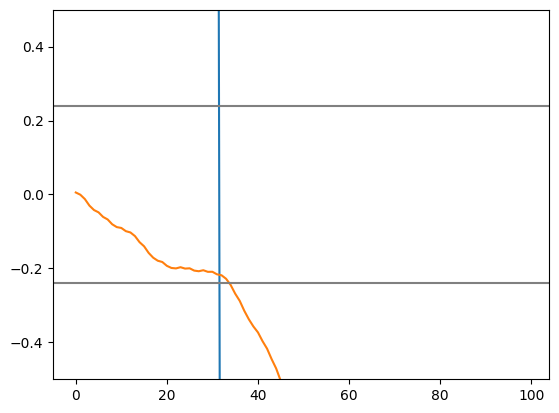

In [48]:
plt.plot( (np.array(rewards)-0.5)*5 )
plt.plot( angles )
plt.ylim(-0.5,0.5)
plt.axhline(y=0.24, color='gray')
plt.axhline(y=-0.24, color='gray')

In [7]:
G = [ [] for i in range(batch_size) ]

In [8]:
G

[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 []]

In [30]:
env.obs

AttributeError: 'LunarLander' object has no attribute 'obs'